# Script based external simulators

In this notebook, we demonstrate the usage of the script based external simulators, summary statistics, and distance functions features.

These allow to use near-arbitrary programing languages and output for pyABC. The main concept is that all communication happens via the file system. This comes at the cost of a considerable overhead, making this feature not optimal for models with a low simulation time. For more expensive models, the overhead should be negligible.

This notebook is similar to the using_R notebook, but circumvents usage of the rpy2 package.

In [ ]:
# install if not done yet
!pip install pyabc --quiet

In [1]:
import pyabc
import pyabc.external

Here, we define model, summary statistics and distance. Note that if possible, alternatively FileIdSumStat can be used to read in the summary statistics directly to python and then use a python based distance function.

In [2]:
dir = "model_r/"

model = pyabc.external.ExternalModel(executable="Rscript", file=f"{dir}/model.r")
sumstat = pyabc.external.ExternalSumStat(executable="Rscript", file=f"{dir}/sumstat.r")
distance = pyabc.external.ExternalDistance(executable="Rscript", file=f"{dir}/distance.r")

dummy_sumstat = pyabc.external.create_sum_stat()  # can also use a real file here

In [3]:
pars = {'meanX': 3, 'meanY': 4}
mf = model(pars)
print(mf)
sf = sumstat(mf)
print(sf)
distance(sf, dummy_sumstat)

{'loc': '/tmp/modelsim_0hz98kjx', 'returncode': 0}
{'loc': '/tmp/sumstat_ywmmq0pc', 'returncode': 0}


4.834298

In [4]:
from pyabc import Distribution, RV, ABCSMC

prior = Distribution(meanX=RV("uniform", 0, 10),
                     meanY=RV("uniform", 0, 10))
abc = ABCSMC(model, prior, distance,
             summary_statistics=sumstat,
             population_size=20)

import os
from tempfile import gettempdir

db = "sqlite:///" + os.path.join(gettempdir(), "test.db")
abc.new(db, dummy_sumstat)

history = abc.run(minimum_epsilon=0.9, max_nr_populations=4)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-11-18 15:45:50>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.34129400e+00.
ABC INFO: Accepted: 20 / 70 = 2.8571e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 2.57219350e+00.
ABC INFO: Accepted: 20 / 45 = 4.4444e-01, ESS: 1.1949e+01.
ABC INFO: t: 2, eps: 2.12528659e+00.
ABC INFO: Accepted: 20 / 53 = 3.7736e-01, ESS: 1.8156e+01.
ABC INFO: t: 3, eps: 1.56643980e+00.
ABC INFO: Accepted: 20 / 65 = 3.0769e-01, ESS: 1.9740e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=2, duration=0:01:20.956890, end_time=2021-11-18 15:47:11>


Note the significantly longer runtimes compared to using rpy2. This is because the simulation time of this model is very short, such that repeatedly accessing the file system creates a notable overhead. For more expensive models, this overhead however becomes less notable. Still, if applicable, more efficient ways of communication between model and simulator are preferable.

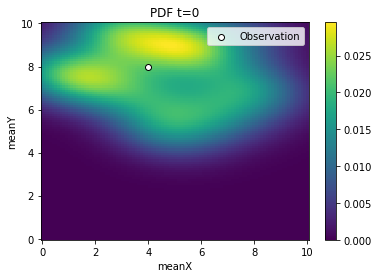

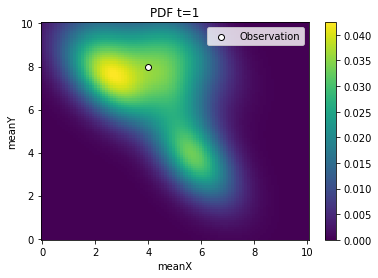

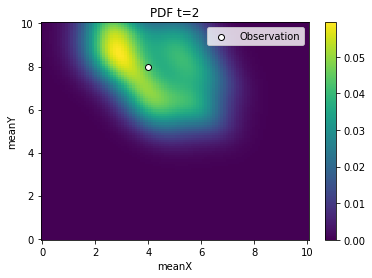

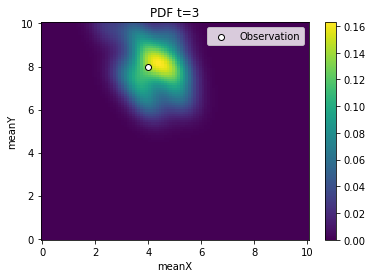

In [5]:
from pyabc.visualization import plot_kde_2d

for t in range(history.n_populations):
    df, w = abc.history.get_distribution(0, t)
    ax = plot_kde_2d(df, w, "meanX", "meanY",
                      xmin=0, xmax=10,
                      ymin=0, ymax=10,
                      numx=100, numy=100)
    ax.scatter([4], [8],
               edgecolor="black",
               facecolor="white",
               label="Observation");
    ax.legend();
    ax.set_title("PDF t={}".format(t))
    